In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import igraph

sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [4]:
df = pd.read_csv('bikesharing/edges.txt', header=None, sep=' ')
df2 = pd.read_csv('bikesharing/stations.csv')
df3 = pd.read_csv('bikesharing/stationID.csv', index_col=0)

In [81]:
df

,0,1,2
0,1,1,33
1,3,1,4
2,4,1,1
3,6,1,2
4,11,1,2
...,...,...,...
188458,615,750,1
188459,646,750,1
188460,708,750,1
188461,746,750,2


In [82]:
df_bss = pd.merge(df2, df3.rename(columns={'id2': 'id'}), on=['id'], how='inner')

In [83]:
df_bss

,id,name,terminalName,lat,long,installed,locked,installDate,removalDate,temporary,nbBikes,nbEmptyDocks,nbDocks,id1
0,1,"River Street , Clerkenwell",1023,51.529163,-0.109971,True,False,1.278947e+12,NaN,False,11,8,19,1
1,2,"Phillimore Gardens, Kensington",1018,51.499607,-0.197574,True,False,1.278586e+12,NaN,False,37,0,37,2
2,3,"Christopher Street, Liverpool Street",1012,51.521284,-0.084606,True,False,1.278240e+12,NaN,False,28,3,32,3
3,4,"St. Chad's Street, King's Cross",1013,51.530059,-0.120974,True,False,1.278241e+12,NaN,False,5,18,23,4
4,5,"Sedding Street, Sloane Square",3420,51.493130,-0.156876,True,False,1.278241e+12,NaN,False,25,2,27,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,746,"Lots Road, West Chelsea",300076,51.479574,-0.179039,True,False,1.385986e+12,NaN,False,13,11,24,773
697,747,"Ormonde Gate, Chelsea",300089,51.487964,-0.161765,True,False,1.385997e+12,NaN,False,15,8,24,774
698,748,"Hertford Road, De Beauvoir Town",300092,51.537278,-0.079202,True,False,1.386160e+12,NaN,False,0,25,25,775
699,749,"Haggerston Road, Haggerston",300081,51.539329,-0.074285,True,False,1.386172e+12,NaN,False,1,35,36,776


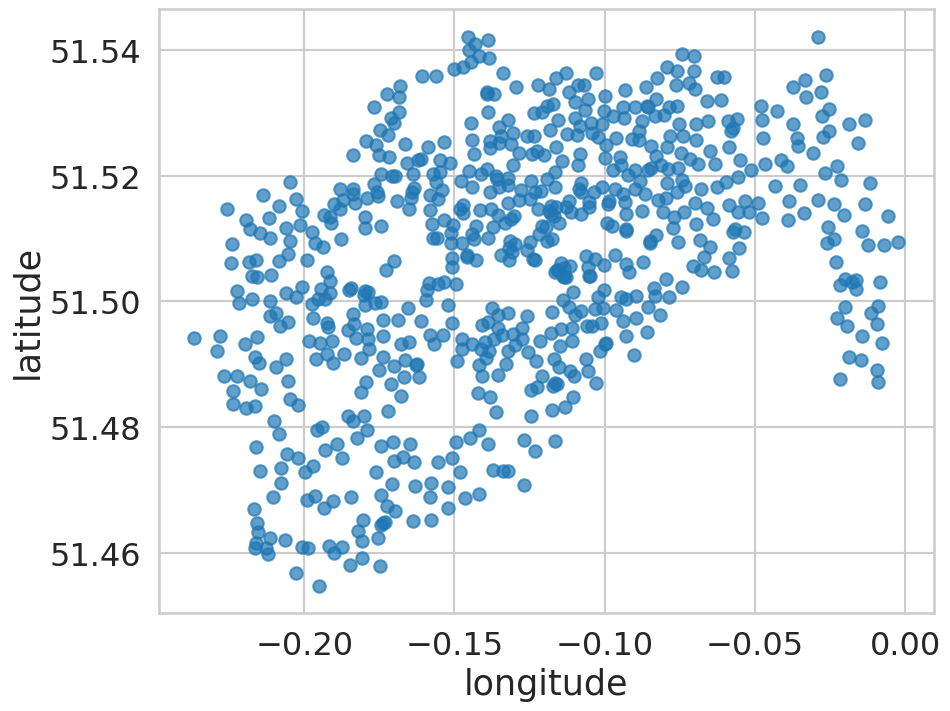

In [84]:
fig, ax = plt.subplots()
ax.scatter(df_bss['long'], df_bss['lat'], alpha=0.7)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.grid(True)
plt.show()

In [121]:
E = df[[0, 1]].values.tolist()
size = len(set([n for e in E for n in e]))
# make an empty adjacency list  
adjacency = np.zeros((size, size))
# populate the list for each edge
for i, (sink, source) in enumerate(E):
    
    adjacency[source-1, sink-1] = df[2][i]
    
def find_missing(lst): 
    return sorted(set(range(lst[0], lst[-1])) - set(lst))

missing = find_missing(df_bss['id'].values.tolist())

missing.reverse()

# delete the missing nodes from the adj matrix, in reverse order so to not mess up the indicies
for missing_node in missing:
    adjacency = np.delete(adjacency, missing_node-1, 0)
    adjacency = np.delete(adjacency, missing_node-1, 1)

# convert to undirected
for i in range(701):
    for j in range(i):
        weight = (adjacency[i, j] + adjacency[j, i]) // 2
        adjacency[i, j] = weight
        adjacency[j, i] = weight
    
np.savetxt("bikesharing/bike_sharing_London_adj_matrix.csv", adjacency, delimiter=",")  

In [122]:
locations = df_bss[['lat', 'long']].to_numpy()
distances = np.zeros((701, 701))
for i in range(701):
    for j in range(701):
        distances[i, j] = np.linalg.norm(locations[i] - locations[j]) * 1000
np.savetxt("bikesharing/bike_sharing_London_distances.csv", distances, delimiter=",")

In [123]:
degrees = np.sum(adjacency, axis=1)
twom = np.sum(adjacency.astype(bool))

In [124]:
B_mod_ng = np.zeros((701, 701))

for i in range(701):
    for j in range(701):
        if i != j:
            B_mod_ng[i, j] = adjacency[i, j] - degrees[i] * degrees[j] / twom

B_mod_ng /= twom
        
np.savetxt("bikesharing/mod_ng.csv", B_mod_ng, delimiter=",")

In [125]:
B_mod_divide_dist = np.zeros((701, 701))

for i in range(701):
    for j in range(701):
        if i != j:
            B_mod_divide_dist[i, j] = adjacency[i, j] - degrees[i] * degrees[j] / distances[i, j]

B_mod_divide_dist /= twom
        
np.savetxt("bikesharing/mod_divide_dist.csv", B_mod_divide_dist, delimiter=",")

In [126]:
B_mod_divide_dist_squared = np.zeros((701, 701))

for i in range(701):
    for j in range(701):
        if i != j:
            B_mod_divide_dist_squared[i, j] = adjacency[i, j] - degrees[i] * degrees[j] / distances[i, j]**2

B_mod_divide_dist_squared /= twom
        
np.savetxt("bikesharing/mod_divide_dist_squared.csv", B_mod_divide_dist_squared, delimiter=",")

In [127]:
B_mod_decay = np.zeros((701, 701))

for i in range(701):
    for j in range(701):
        if i != j:
            B_mod_decay[i, j] = adjacency[i, j] - degrees[i] * degrees[j] / np.exp(distances[i, j])

B_mod_decay /= twom
        
np.savetxt("bikesharing/mod_decay.csv", B_mod_decay, delimiter=",")

In [135]:
min_dist = np.min(distances)
max_dist = np.max(distances)

dist_range = max_dist - min_dist

bin_num = int(dist_range // 5 + 1)

bins = np.zeros(bin_num)

for i in range(bin_num):
    
    numerator = 0
    denominator = 0
    for u in range(701): 
        for v in range(u):

            if distances[u, v] >= 5 * i or distances[u, v] < 5 * (i+1):
                numerator += adjacency[u, v]
                denominator += adjacency[u, v]**2
                
    bins[i] = numerator / denominator
    
B_mod_simple_bin_5 = np.zeros((701, 701))

for i in range(701):
    for j in range(i):
        if i != j:
            
            P = bins[int(distances[i, j] // 5)]
            
            B_mod_simple_bin_5[i, j] = adjacency[i, j] - P
            B_mod_simple_bin_5[j, j] = adjacency[i, j] - P

B_mod_simple_bin_5 /= twom
        
np.savetxt("bikesharing/mod_simple_bin_5.csv", B_mod_decay, delimiter=",")

In [138]:
dist_range

234.9903222259496

In [136]:
bin_num = int(dist_range // 10 + 1)

bins = np.zeros(bin_num)

for i in range(bin_num):
    
    numerator = 0
    denominator = 0
    for u in range(701): 
        for v in range(u):

            if distances[u, v] >= 10 * i or distances[u, v] < 10 * (i+1):
                numerator += adjacency[u, v]
                denominator += adjacency[u, v]**2
                
    bins[i] = numerator / denominator

B_mod_simple_bin_10 = np.zeros((701, 701))

for i in range(701):
    for j in range(i):
        if i != j:
            
            P = bins[int(distances[i, j] // 10)]
            
            B_mod_simple_bin_10[i, j] = adjacency[i, j] - P
            B_mod_simple_bin_10[j, j] = adjacency[i, j] - P

B_mod_simple_bin_10 /= twom
        
np.savetxt("bikesharing/mod_simple_bin_10.csv", B_mod_decay, delimiter=",")

In [137]:
bin_num = int(dist_range // 20 + 1)

bins = np.zeros(bin_num)

for i in range(bin_num):
    
    numerator = 0
    denominator = 0
    for u in range(701): 
        for v in range(u):

            if distances[u, v] >= 20 * i or distances[u, v] < 20 * (i+1):
                numerator += adjacency[u, v]
                denominator += adjacency[u, v]**2
                
    bins[i] = numerator / denominator

B_mod_simple_bin_20 = np.zeros((701, 701))

for i in range(701):
    for j in range(i):
        if i != j:
            
            P = bins[int(distances[i, j] // 20)]
            
            B_mod_simple_bin_20[i, j] = adjacency[i, j] - P
            B_mod_simple_bin_20[j, j] = adjacency[i, j] - P

B_mod_simple_bin_20 /= twom
        
np.savetxt("bikesharing/mod_simple_bin_20.csv", B_mod_decay, delimiter=",")

In [139]:
bin_num = int(dist_range // 100 + 1)

bins = np.zeros(bin_num)

for i in range(bin_num):
    
    numerator = 0
    denominator = 0
    for u in range(701): 
        for v in range(u):

            if distances[u, v] >= 100 * i or distances[u, v] < 100 * (i+1):
                numerator += adjacency[u, v]
                denominator += adjacency[u, v]**2
                
    bins[i] = numerator / denominator

B_mod_simple_bin_100 = np.zeros((701, 701))

for i in range(701):
    for j in range(i):
        if i != j:
            
            P = bins[int(distances[i, j] // 100)]
            
            B_mod_simple_bin_100[i, j] = adjacency[i, j] - P
            B_mod_simple_bin_100[j, j] = adjacency[i, j] - P

B_mod_simple_bin_100 /= twom
        
np.savetxt("bikesharing/mod_simple_bin_100.csv", B_mod_decay, delimiter=",")

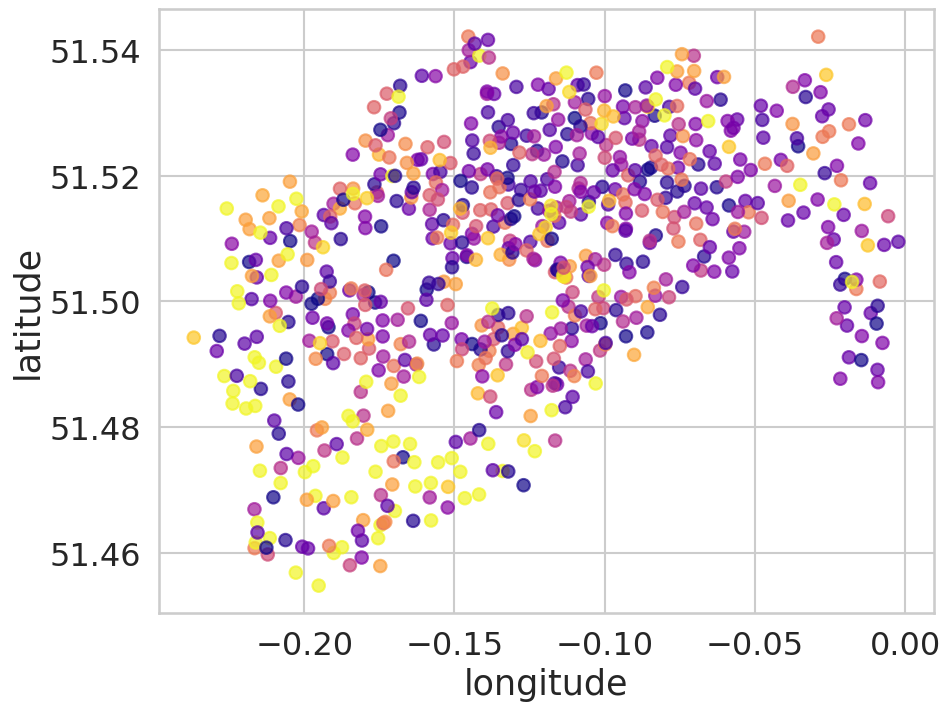

In [149]:
mod_ng_communities = np.genfromtxt('bikesharing/mod_ng_communities.csv',
                                                    delimiter=',')
fig, ax = plt.subplots()
ax.scatter(df_bss['long'], df_bss['lat'], alpha=0.7, 
           c=mod_ng_communities, cmap='plasma')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.grid(True)
plt.show()

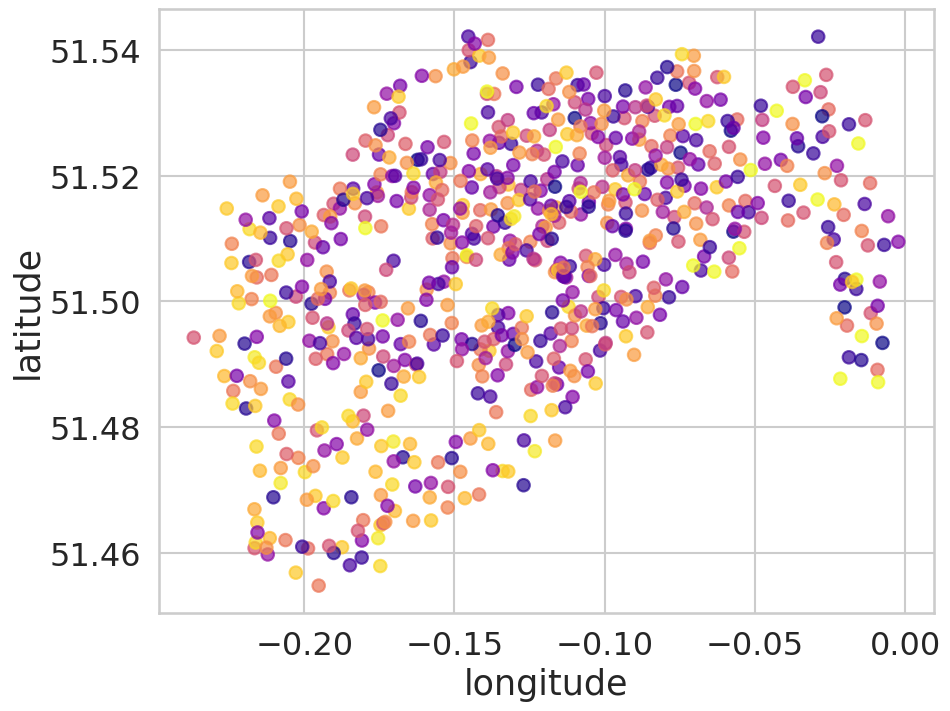

In [147]:
mod_decay_communities = np.genfromtxt('bikesharing/mod_decay_communities.csv',
                                              delimiter=',')
fig, ax = plt.subplots()
ax.scatter(df_bss['long'], df_bss['lat'], alpha=0.7, 
           c=mod_decay_communities, cmap='plasma')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.grid(True)
plt.show()

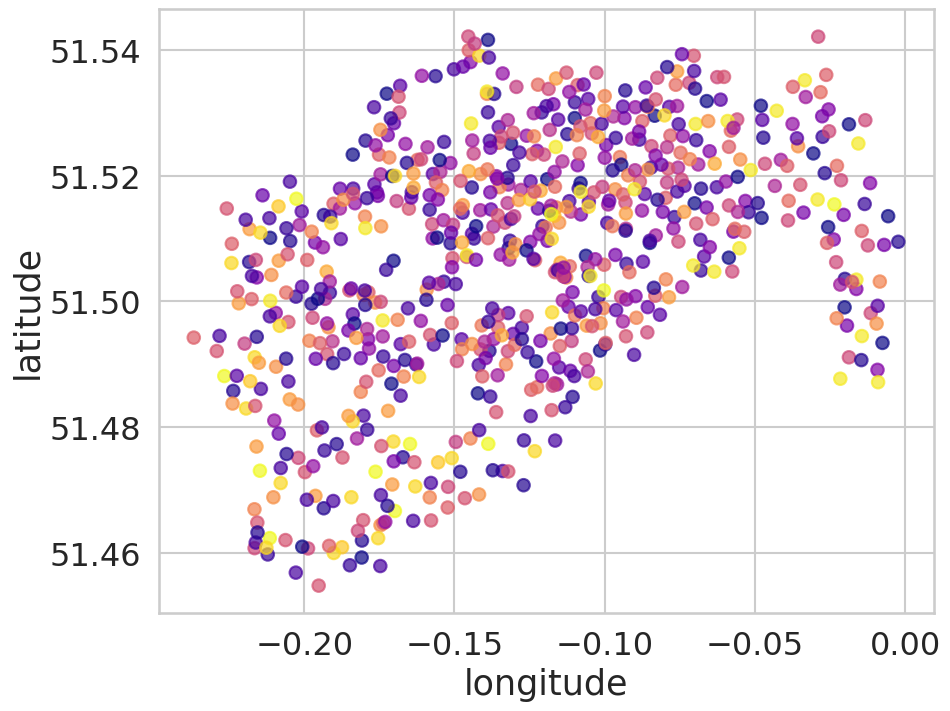

In [145]:
mod_simple_bin_20_communities = np.genfromtxt('bikesharing/mod_simple_bin_20_communities.csv',
                                              delimiter=',')
fig, ax = plt.subplots()
ax.scatter(df_bss['long'], df_bss['lat'], alpha=0.7, 
           c=mod_simple_bin_20_communities, cmap='plasma')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.grid(True)
plt.show()